<a href="https://colab.research.google.com/github/ssnirgudkar/Datasetpaper-final/blob/main/pspnet_pytorch_Finalpaper_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Encoder - se_resnext50_32x4d, Decoder - FPN, 100 epochs. FPN = next generation pspnet 
This is the final code that should be used

## you need to create the model folder in the drive till the actual file path. model.save only creates the file not the folder

https://github.com/qubvel/segmentation_models.pytorch/blob/master/examples/cars%20segmentation%20(camvid).ipynb

** our masked image is gray scale with 1 channel (height * width*channel=1). and the pixel values are equal to the class ids. Each pixle value is only 1 value and not (a*b*c). The CV2.imread, with a flag od 0 that reads it as a gray scalae does not work for our images although it works for the other dataset

## image size: (256, 320) #it's height and width
## Mask - channel - , size - extension.png, gray scale

## Use GPU so that CUDA is available

##Run1
1. train - 2570, val - 740, test - 370 , Epochs - 500 
2. batchsize - 10 for train, 5 for validation. 
3. train running with 4 worker threads, validation with 1.
4. i am not using augmentation, and no existing encoder weights.
5. Training time - 11 hrs  hrs. Testing time -  8 min

##Run2
1. train - , val - , test - , Epochs - 100
2. NO preloaded / imagenet weights 
2. batchsize - 10 for train, 5 for validation. 
3. train running with 4 worker threads, validation with 1.
4. i am not using augmentation, and no existing encoder weights.
5. Training time - hrs. Testing time -   min

##Run3
1. train -24814 , val - 7090, test - 3544, Epochs - 76(failed on 77th)
2. NO preloaded / imagenet weights 
2. batchsize - 10 for train, 5 for validation. 
3. train running with 4 worker threads, validation with 1.
4. i am not using augmentation, and no existing encoder weights.
5. Training time - 18 hrs. Testing time -  1hr 15 min

##Run4
1. train - 3438 , val - 982 , test - 492 , Epochs - 50
2. NO preloaded / imagenet weights 
2. batchsize - 10 for train, 5 for validation. 
3. train running with 4 worker threads, validation with 1.
4. i am not using augmentation, and no existing encoder weights.
5. Training time - 1 hrs. Testing time -  5 min
Model - pspnet-pytorch-finalpapersubmission_V2
##Even with 100 epocs 346 images of the 491 have a few pixels that are not mapped and have a value of 0. need to check in the architecture

##Run5
size - actual size , 2020 only 
1. train - 3438 , val - 982 , test - 492 , Epochs - 50
2. NO preloaded / imagenet weights 
2. batchsize - 10 for train, 5 for validation. 
3. train running with 4 worker threads, validation with 1.
4. i am not using augmentation, and no existing encoder weights.
5. Training time - 1 hrs. Testing time -  5 min
Model - pspnet-pytorch-finalpapersubmission_V2
##Even with 100 epocs 346 images of the 491 have a few pixels that are not mapped and have a value of 0. need to check in the architecture



#To Do - 
1. Right now dice loss and iau for accuracy. check if we need to select any other metrics 
2. We are not plotting the losses / accuracy. need to check what to use to get the plots. should that be consistent across all the models? in that case should we use tensorboard?
3. collapse all classes into 1 complete image 
4. get the file name automatically based on the run number, instead of having to manually add it while saving the image on drive
5. Ensure that the sort order is the same between unet and pspnet so that we know that its the same image 
6. HUman objects are really bad in pspnet. many ob are also missed if they are small. check if any parameter needs to be changed

In [ ]:
!nvidia-smi

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# Install required libs
!pip install -U segmentation-models-pytorch albumentations --user

In [4]:
!pip uninstall -y segmentation-models-pytorch

Found existing installation: segmentation-models-pytorch 0.2.1
Uninstalling segmentation-models-pytorch-0.2.1:
  Successfully uninstalled segmentation-models-pytorch-0.2.1


In [ ]:
!git clone https://github.com/Cadene/pretrained-models.pytorch.git
!git clone https://github.com/qubvel/segmentation_models.pytorch
!git clone https://github.com/alexgkendall/SegNet-Tutorial

In [ ]:
#!pip install -U segmentation-models-pytorch albumentations --user
#!pip uninstall -y segmentation-models-pytorch
#!pip install segmentation_models_pytorch

!pip install git+https://github.com/IvyGongoogle/pretrained-models.pytorch
!pip install git+https://github.com/lukemelas/EfficientNet-PyTorch


In [ ]:
#!pip install efficientnet-pytorch
#!pip install pretrainedmodels 

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch


# Restart Runtime now from the MENU !!! 

In [1]:
import torch
import numpy as np
import torch.nn as nn
import segmentation_models_pytorch as smp

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [4]:
torch.cuda.is_available()

True

In [5]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/train.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/trainannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/val.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/valannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

In [9]:
import os 
APP_FOLDER = '/content/IRDatasetFinal/train'
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
   

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/IRDatasetFinal/train
Total number of files 10562
Total Number of directories 0
Total: 10562


In [10]:
#DATA_DIR = '/content/drive/MyDrive/TheIRDatasetMini'
#DATA_DIR = '/content/drive/MyDrive/TheIRDatasetMini_backup'
#DATA_DIR = '/content/drive/MyDrive/psp-1.0'
DATA_DIR = '/content/IRDatasetFinal'
# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [11]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

#x_test_dir = os.path.join(DATA_DIR, 'test')
#y_test_dir = os.path.join(DATA_DIR, 'testannot')

NUM_CLASSES = 7 
CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']

#image_width = 320
#image_height = 256
  
image_width = 640
image_height = 512

train_batch_size = 10 
val_batch_size = 5 

#learning rate 
lr=0.001 

#epoch +1 as range is used 
epoch = 51
 


In [12]:
# helper function for data visualization
### TO DO - CHANGE THE COLOR MAP IN MATPLOTLIB FOR CONSISTENCY
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

In [13]:
import PIL
#def visualize2(input_image, input_mask, predicted_mask):
def visualize2(predicted_mask,sequence,imagename):
    #NUM_CLASSES = 7
    """Quick utility to display a model's prediction. we need color masked images, so displaying both color and black and white"""
                   
    #0 - sky(dark.blue). 
    #1 - water(light.blue).   
    #2 - bridge(yellow).   
    #3 - obstacle(purple).  
    #4- living ob(green).  
    #5- backgnd (orange). 
    #6 - self(pink)
    #7 - null values. white
    # Colors are same as segments.ai scheme
    
    label_colours = [(0,113,188), (216,82,24), (236,176,31), (125, 46, 141), (118, 171, 47), (161, 19, 46), (255,0,0), (255,255,255)]  
    
    #print("mask shape = ", np.shape(predicted_mask))
    #print("Unique pixel values = ", np.unique(predicted_mask))
    #print("Type of mask = ", type(predicted_mask))
    

    img1 = PIL.Image.new('RGB', (image_width, image_height))
    pixels = img1.load()
    #print(type(pixels))
    #print(pixels[0,0])
    #converting incoming predicted mask from float to an int 
    int_predicted_mask = predicted_mask.astype(int)
    #for j_, j in enumerate(predicted_mask[:, :]):
    for j_, j in enumerate(int_predicted_mask[:, :]):  
        #print (j_, j)
        for k_, k in enumerate(j):
              #print(k_, k)
              if k < NUM_CLASSES:
                 pixels[k_,j_] = label_colours[k]
    output = np.array(img1)
    
    #print("this is the colored inferred image")
    display(img1)

    #save inferred image 
    #img1.save('/content/drive/MyDrive/IRdatasetmini-inferences/pspnet/picture/' + str(sequence) + '--run1--' + imagename)
    img1.save('/content/drive/MyDrive/IRDatasetFinal-Inferences/pspnet/picture/' + str(sequence) + '--run2020-1--' + imagename)

In [14]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [15]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """

    #0 - sky 1 - water 2 - bridge 3 - obstacle 4- living ob  5- backgnd 6 - self  
               
    
    #CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
    #NUM_CLASSES = 7              
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = sorted([os.path.join(images_dir, image_id) for image_id in self.ids])
        self.masks_fps = sorted([os.path.join(masks_dir, image_id) for image_id in self.ids])
        
        #mask1 = cv2.imread(self.masks_fps[1], cv2.IMREAD_UNCHANGED)
        #print("true value of image", np.unique(mask1))
        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        self.class_values = [CLASSES.index(cls.lower()) for cls in classes]

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #HAD TO CHANGE FLAG 0 TO IM_READ_UNCHANGED BELOW as it was not reading the pixel values otherwise 
        # mask = cv2.imread(self.masks_fps[i], 0)
        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        #print ("masked image values", mask)
        #print ("masked shape values", mask.shape)
        #print("masked unique values", np.unique(mask))
        #print("pixel values of mask", mask)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        #print ("masks extraction", masks)
        mask = np.stack(masks, axis=-1).astype('float')
        #print("stacks of classes for mask", masks)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            #print('masked array first', np.unique(mask))
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

In [ ]:
'''
# Lets look at data we have. it can only put 1 class at a time 

#CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
dataset = Dataset(x_train_dir, y_train_dir, classes= ["background"])

image, mask = dataset[2569] # get some sample. 


'''
#just picking 1 image from the train dataset. Also selecting only class 'obstacle'. 
#the stacks of classes change when i change the class to sky. so the visualize is only showing the array for that specific class. 
# it's boolean - yes or No. Sp it will say if every pixel belongs to that class or not. it's able to print the ground truth properly
#which means dataset is created properly. 
'''
#print ('masked array' , np.unique(mask))
visualize(
    image=image, 
    cars_mask=mask.squeeze(),
   
)
'''

In [16]:
import albumentations as albu

In [17]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


'''
OpenCV img = cv2.imread(path) loads an image with HWC-layout (height, width, channels), 
while Pytorch requires CHW-layout. So we have to do np.transpose(image,(2,0,1))
for HWC->CHW transformation.
'''
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

In [ ]:
#### Visualize resulted augmented images and masks - thows error after 1st picture. 
#THIS IS NOT NECESSARY. plus our images have some augmentation
'''
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['obstacle'],
)

# same image with different random transforms
#for i in range(3):  (Had to comment this out as i only have 1 image. will remove during actual training)
for i in range(3):
   image, mask = augmented_dataset[1]
   visualize(image=image, mask=mask.squeeze(-1))
   '''

In [18]:
ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
#CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
ACTIVATION = 'softmax2d' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

# create segmentation model with pretrained encoder
model = smp.FPN(
    encoder_name=ENCODER, 
    #encoder_weights=ENCODER_WEIGHTS, Do not want to use existing encoder weights. 
    encoder_weights=None, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)
'''if i use existing encoder weights, then it doesn't display all classes in the prediction for some reason. 
    have not found out exactly why. but perhaps std classes as sky / water are being taken up from the weights. 
    obstacle , backngd are not standard and therefore may not be plotted. So i will train the model from scratch
''' 


"if i use existing encoder weights, then it doesn't display all classes in the prediction for some reason. \n    have not found out exactly why. but perhaps std classes as sky / water are being taken up from the weights. \n    obstacle , backngd are not standard and therefore may not be plotted. So i will train the model from scratch\n"

In [19]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    #augmentation=get_training_augmentation(), try w/o augmentation 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES, 
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    #augmentation=get_validation_augmentation(), try w/o augmentation
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, train_batch_size, shuffle=True, num_workers=4)
#train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=12) - used for running iwth 1 image
valid_loader = DataLoader(valid_dataset, val_batch_size, shuffle=False, num_workers=1)

In [20]:

loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
    #dict(params=model.parameters(), lr=0.001),  #changed learning rate to keep it consistent 
])

In [21]:
train_epoch = smp.utils.train.TrainEpoch(
    model, #use for 1st training. 
    #best_model, #use this for retraining
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    #best_model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [23]:
###### THIS IS WHERE YOU ARE TRAINING THE MODEL. ONLY RUN IF YOU WANT TO TRAIN
max_score = 0

for i in range(0, epoch):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Models/pspnet/pspnet-pytorch-finalpapersubmission-2020only/best_model.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 528/528 [02:01<00:00,  4.35it/s, dice_loss - 0.03597, iou_score - 0.9357]
Model saved!

Epoch: 1
valid: 100%|██████████| 528/528 [01:57<00:00,  4.51it/s, dice_loss - 0.03032, iou_score - 0.9444]
Model saved!

Epoch: 2
valid: 100%|██████████| 528/528 [01:57<00:00,  4.48it/s, dice_loss - 0.0247, iou_score - 0.9536]
Model saved!

Epoch: 3
valid: 100%|██████████| 528/528 [01:58<00:00,  4.46it/s, dice_loss - 0.02151, iou_score - 0.9591]
Model saved!

Epoch: 4
valid: 100%|██████████| 528/528 [01:57<00:00,  4.51it/s, dice_loss - 0.0214, iou_score - 0.9594]
Model saved!

Epoch: 5
valid: 100%|██████████| 528/528 [01:55<00:00,  4.57it/s, dice_loss - 0.01991, iou_score - 0.9621]
Model saved!

Epoch: 6
valid: 100%|██████████| 528/528 [01:57<00:00,  4.50it/s, dice_loss - 0.01833, iou_score - 0.965]
Model saved!

Epoch: 7
valid: 100%|██████████| 528/528 [01:56<00:00,  4.52it/s, dice_loss - 0.01834, iou_score - 0.965]

Epoch: 8
valid: 100%|██████████| 528/528 [01:55<

In [ ]:
### THIS IS WHERE YOU LOAD THE MODEL FOR YOUR USE. FOR INFERENCE YOU CAN JUST START WITH THIS W/O TRAINING
best_model = torch.load('/content/drive/MyDrive/Models/pspnet/pspnet-pytorch-finalpapersubmission-2020only/best_model.pth')

## below line is if we want to run using cpu
#best_model = torch.load('/content/drive/MyDrive/Models/pspnet-pytorch/best_model.pth', map_location=torch.device('cpu')) 


In [ ]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    #x_train_dir, - check with trained images to see if that gives any prediction
    #y_train_dir,
    #augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
    
)

test_dataloader = DataLoader(test_dataset, shuffle=False, num_workers=1)


In [ ]:
## evaluate model on test set. THIS IS WHERE YOU ARE TESTING THE TEST DATA SET ON THE MODEL
test_epoch = smp.utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

logs = test_epoch.run(test_dataloader)

valid: 100%|██████████| 491/491 [00:14<00:00, 34.20it/s, dice_loss - 0.01979, iou_score - 0.9634]


In [ ]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
    #x_train_dir, y_train_dir, - checking with train dataset 
    classes=CLASSES,
    
)

In [ ]:
from torchvision.utils import save_image
import torch
import torchvision

In [ ]:
'''
## THIS CODE PREDICTS ONE CLASS AT A TIME. NOT NEEDED NOW DUE TO FUSION. KEEPING IT TO DEBUG AS NECESSARY
#CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
import numpy as np 
DEVICE = 'cuda'
for i in range(1):
    #the below line will visualize for any random sample. we need specific. so i have removed it. keep changing value of n. 
    # i think value of i should loop thru no of classes.but we cna check it later
    #n = np.random.choice(len(test_dataset))
    n = 2
    image_name = os.listdir(x_test_dir)[n]
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset[n]
        
    #image_vis = test_dataset_vis[10][0].astype('uint8')
    #image, gt_mask = test_dataset[10]
    '''
    print('gt mask before squeeze - 0', np.unique(gt_mask[0]))
    print('gt mask before squeeze - 1', np.unique(gt_mask[1]))
    print('gt mask before squeeze - 2', np.unique(gt_mask[2]))
    print('gt mask before squeeze - 3', np.unique(gt_mask[3]))
    print('gt mask before squeeze - 4', np.unique(gt_mask[4]))
    print('gt mask before squeeze - 5', np.unique(gt_mask[5]))
    print('gt mask before squeeze - 6', np.unique(gt_mask[6]))
    '''
    if (np.unique(gt_mask[3]).any() == 1) or (np.unique(gt_mask[4]).all() == 0):  
       print ("there are living ob and obstacles")
       print("Name of the image being predicted",os.listdir(x_test_dir)[n])
       gt_mask = gt_mask.squeeze()
       x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
       #x_tensor = torch.from_numpy(image).unsqueeze(0)
       pr_mask = best_model.predict(x_tensor)
       pr_mask1 = (pr_mask.squeeze().cpu().numpy().round())
       print("type of pr_mask",type(pr_mask))
       #print(pr_mask[0])
       #print("x shape = {0}".format(x_tensor.shape))
       #print ("shape of pr mask", pr_mask.shape)
       #print ("shape of gt mask", gt_mask.shape)
       #print ("shape of pr mask1", pr_mask1.shape)

       #print("unique values of pr mask", np.unique(pr_mask[0]))
       #print("unique values of gt mask", np.unique(gt_mask))
       #print("unique values of pr mask", np.unique(pr_mask1[0]))
       print("unique values of pr mask1", np.unique(pr_mask1[2]))

       #want to save the array as an image#
       img1 = pr_mask.squeeze()
       #print ("shape of img1 after squeeze", img1.shape)
       #print ("type of img1 after squeeze", type(img1))
       # we are only saving 1 class at a time. since we want obstacles, i have put 3 in the array below#
       #save_image(img1[3], '/content/drive/MyDrive/TheIRDataset-Inferences/pspnet/Prediction-obstacles/0--run1--1570555911.468876_1_2.png') 
       #instead of hardcoding the name, dynamically getting it from the value of n
       #save_image(img1[3], '/content/drive/MyDrive/IRdatasetmini-inferences/pspnet/Prediction-obstacles/0--run1--' + image_name)
    
       #CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
       #              0.      1.       2.        3             4                 5           6
       visualize(
          image=image_vis, 
          ground_truth_mask=gt_mask[2], 
          predicted_mask=pr_mask1[2]
               )
       
       visualize2(
          #image=image_vis, 
          #ground_truth_mask=gt_mask[3], 
          predicted_mask=pr_mask1[2]
               )
'''

In [ ]:
'''
mask_image = cv2.imread("/content/img1.png", cv2.IMREAD_UNCHANGED)
print(np.unique(mask_image))
print(mask_image)
'''

The predicted mask of dimensions (7,256,320) is collapsed into (256,320) 2D array. The (7,256,320) 3D array is a binary mask for each type of class. 7 layers correspond to 7 classes. E.g. in 0th layer, if sky is present (class id=0) then that array entry will be 1 everything else will be 0. So when we convert this 3D array to 2D array, 0th slice is multiplied by 1, 1st slice by 2, .. so on and so forth. This preserves the information of 0th class ID. Then all the 2D slices are summed up to obtain (256,320) mask image. Then, 1 is subtracted from this 2D array so that the class IDs match with ground truth.
Now, theoretically speaking, there should not be any 0 values in predicted mask because we are multiplying sky mask (class id=0) with 1 so where ever sky is present, it will produce 1 and rest of the entries will be occupied by other classes. However, there are some spurious entries with value 0 in the prediction mask. There are anomaly or noise. I need to decide what should be done with it.
1. Check if PSPNet is happy with ground truth having 0 as valid class id. Many a times, there is hidden assumption that the class id will not be 0. WaSR had such assumption which was explicitly stated. If PSPNet has such assumption then I will need to regenerate/preprocess all the ground truth masks such that sky is 1, water is 2 etc. and then we should try PSPNet again.

There are living obstacles and obstacles in the image a1603211549_012884_1_2.png
The position of the file is 59
indices where collapsed_pr_mask1_sqz has 0 value =  (array([37, 53, 56, 56, 57, 57, 58, 58, 58, 59, 77, 80, 81, 82, 85, 86, 87,
       87, 93]), array([107, 117, 310, 314, 201, 315, 263, 264, 265, 274, 199,  50,  51,
        52,  12,  55,  55, 117,  48]))


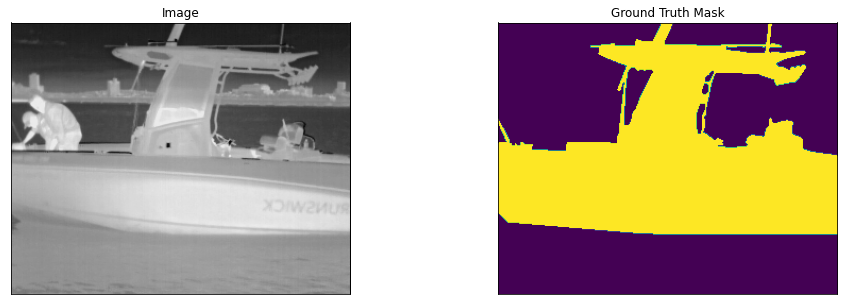

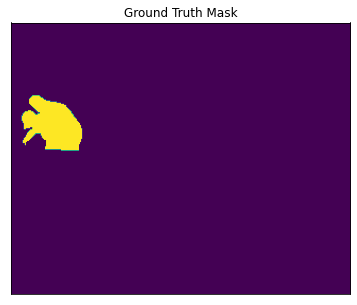

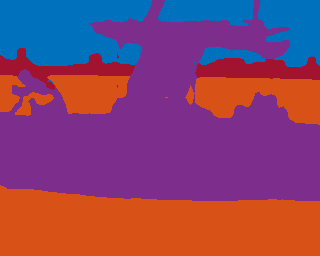

There are living obstacles and obstacles in the image a1635459784_017659_1.png
The position of the file is 60
indices where collapsed_pr_mask1_sqz has 0 value =  (array([ 0,  1, 49, 76, 77, 77, 77, 77, 77, 77, 77, 77, 77, 78, 78, 78, 78,
       78, 78, 78, 78, 78, 78, 78, 78, 78, 78, 79, 79, 79, 79, 79, 79, 79,
       80, 80, 80, 81, 81, 82, 83, 83, 84, 85, 85, 85, 86, 86, 87, 88, 89]), array([267, 300, 259, 316, 165, 166, 169, 179, 190, 191, 192, 193, 194,
       164, 168, 169, 173, 182, 183, 187, 188, 189, 190, 191, 192, 193,
       194, 172, 173, 188, 189, 191, 192, 193, 189, 192, 193, 189, 192,
       251, 190, 210, 190, 189, 191, 209, 189, 209, 189, 189, 189]))


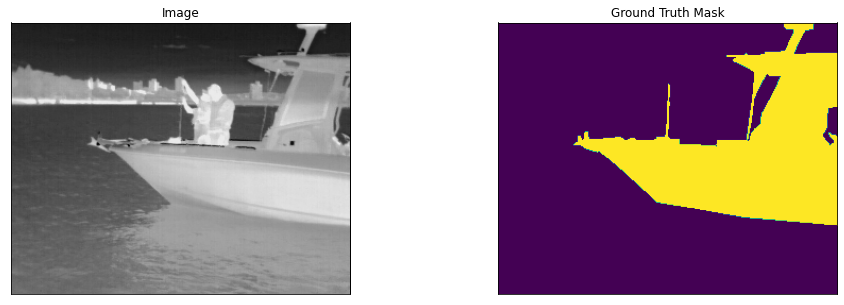

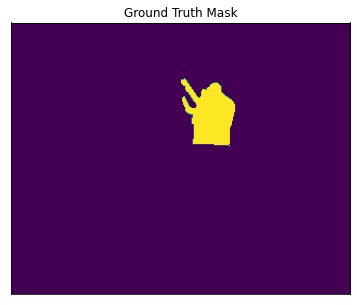

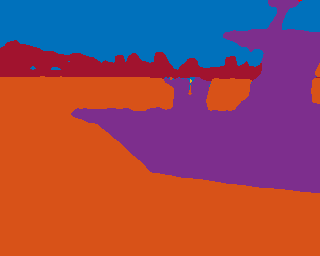

There are living obstacles and obstacles in the image a1571166207_947669_1.png
The position of the file is 61
indices where collapsed_pr_mask1_sqz has 0 value =  (array([55, 57, 59, 60, 60, 80]), array([30, 27, 78, 17, 76, 26]))


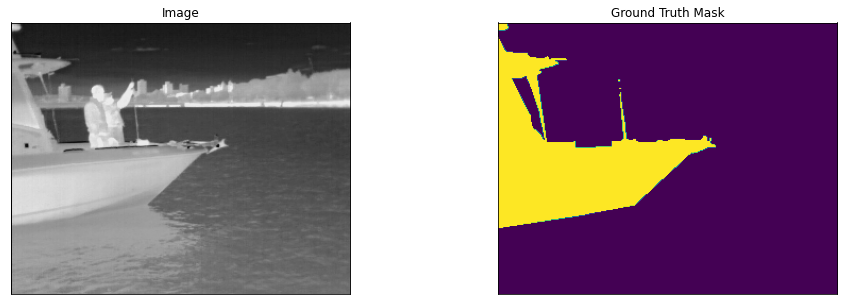

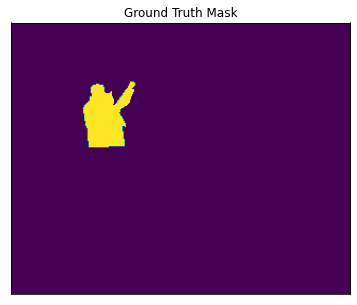

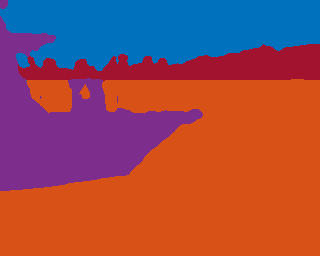

There are living obstacles and obstacles in the image a1571166264_546560_1_2.png
The position of the file is 62
indices where collapsed_pr_mask1_sqz has 0 value =  (array([76, 77, 79, 79, 87, 87, 88, 89, 89, 89, 89, 90, 90, 91, 91, 92, 93,
       93, 94, 94]), array([275, 260, 258, 295, 266, 267, 265, 263, 264, 266, 268, 263, 268,
       263, 267, 267, 262, 267, 263, 264]))


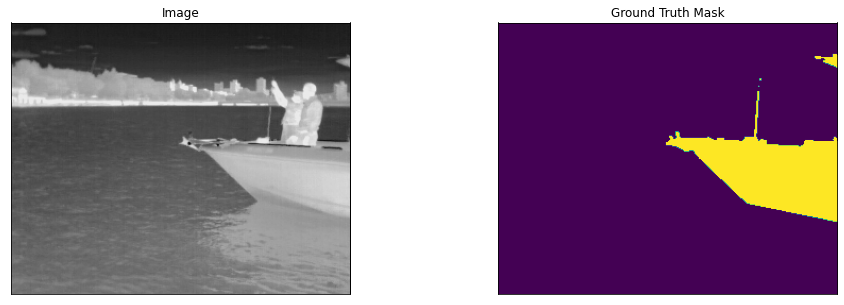

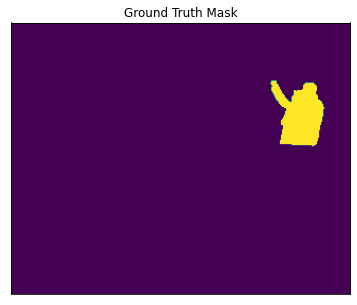

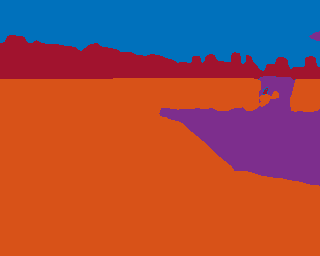

There are living obstacles and obstacles in the image a1572379044_662103_1_2.png
The position of the file is 67
indices where collapsed_pr_mask1_sqz has 0 value =  (array([75, 75, 75, 75, 75, 76, 77, 77]), array([ 99, 100, 104, 106, 289, 117,  93,  94]))


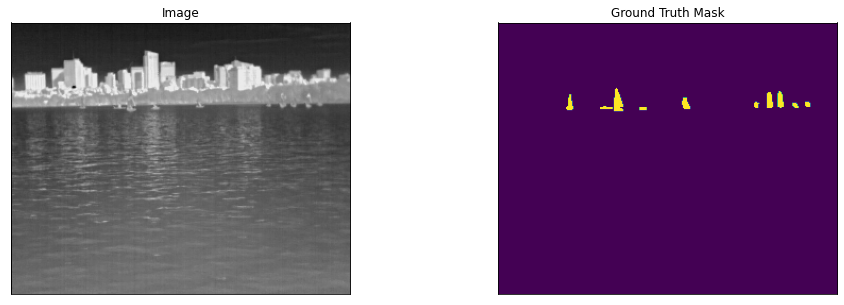

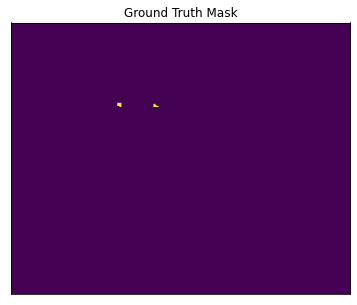

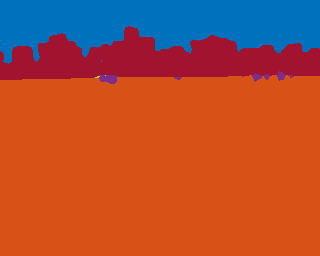

There are living obstacles and obstacles in the image a1571168223_764071_1.png
The position of the file is 68
indices where collapsed_pr_mask1_sqz has 0 value =  (array([75, 76]), array([50, 74]))


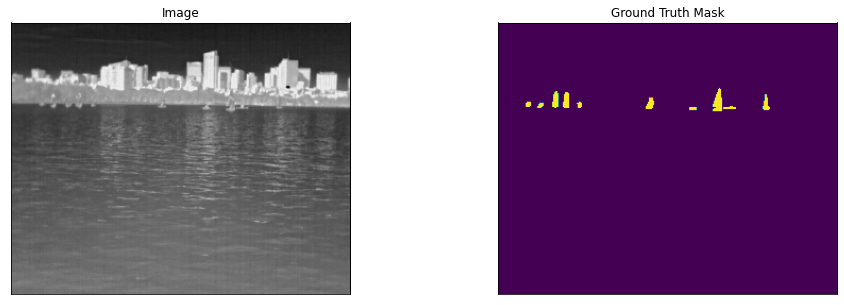

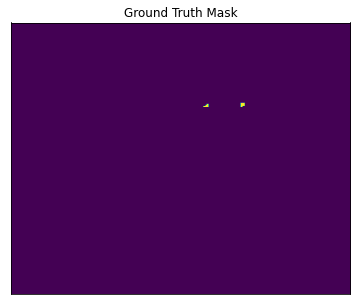

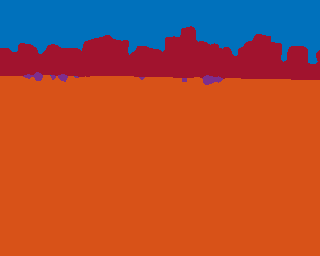

There are living obstacles and obstacles in the image a1571167266_269071_1.png
The position of the file is 69
indices where collapsed_pr_mask1_sqz has 0 value =  (array([71, 72, 72, 73]), array([273, 272, 282, 239]))


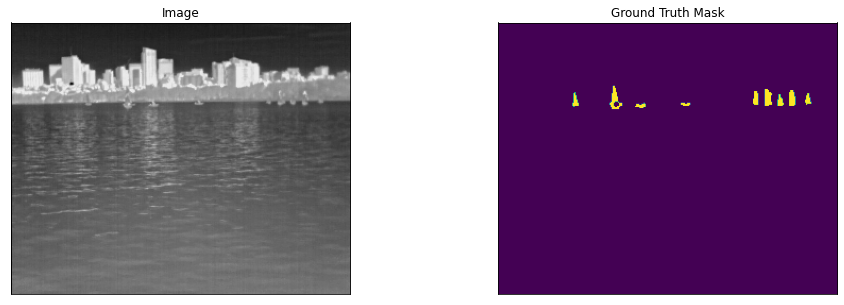

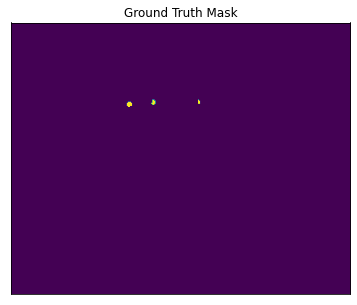

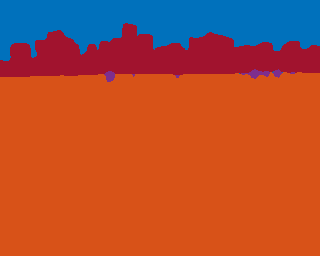

There are living obstacles and obstacles in the image a1622943321_197496_1.png
The position of the file is 70
indices where collapsed_pr_mask1_sqz has 0 value =  (array([74, 74, 75, 75, 75, 75, 75]), array([105, 240, 102, 103, 117, 118, 293]))


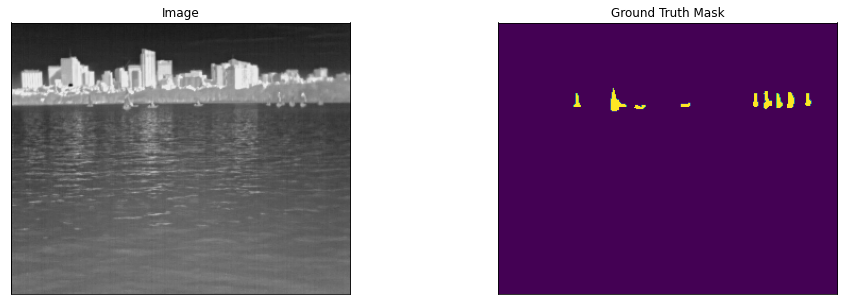

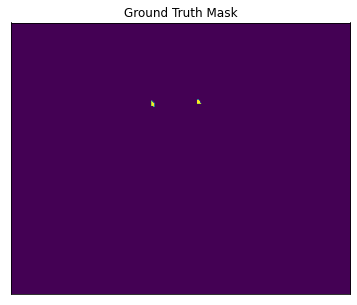

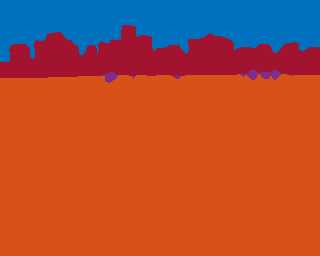

There are living obstacles and obstacles in the image a1570561110_825702_1.png
The position of the file is 71
indices where collapsed_pr_mask1_sqz has 0 value =  (array([75]), array([180]))


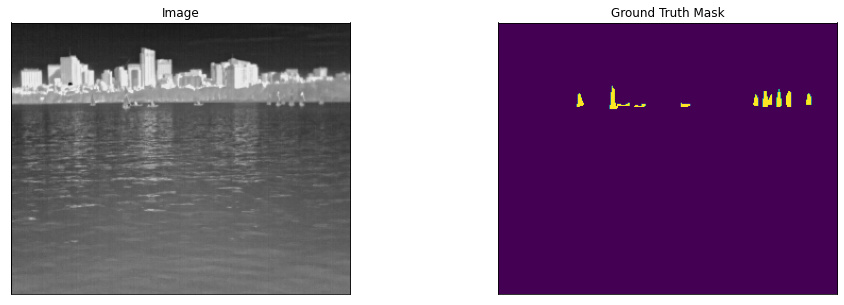

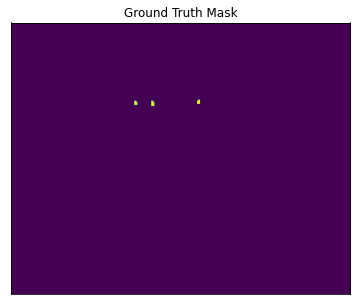

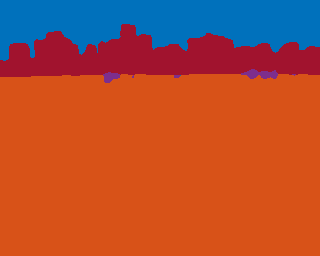

There are living obstacles and obstacles in the image a1572379382_054355_1_2.png
The position of the file is 72
indices where collapsed_pr_mask1_sqz has 0 value =  (array([76]), array([242]))


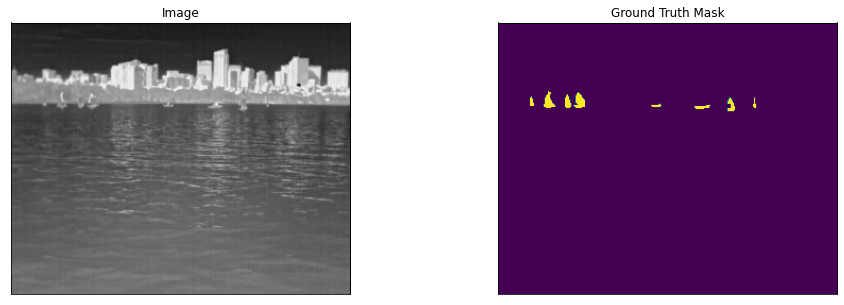

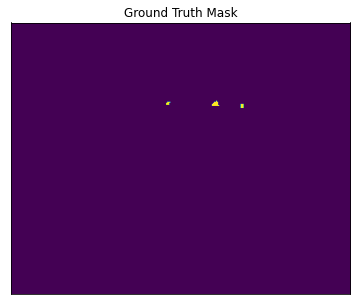

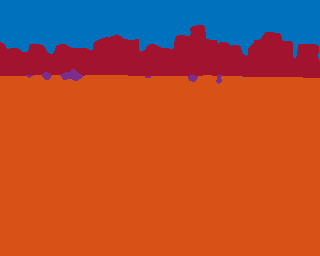

There are living obstacles and obstacles in the image a1571166257_980054_1_2.png
The position of the file is 73
indices where collapsed_pr_mask1_sqz has 0 value =  (array([75, 75, 75, 77, 77, 77, 77, 77, 77, 77, 77]), array([ 42,  64,  73, 189, 190, 191, 192, 193, 194, 256, 259]))


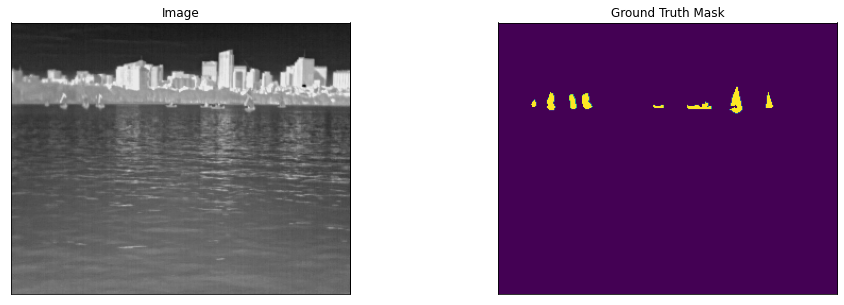

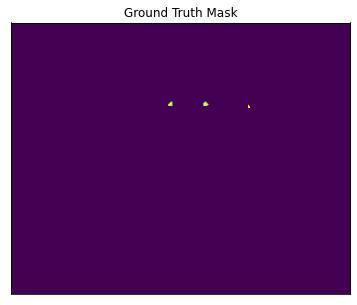

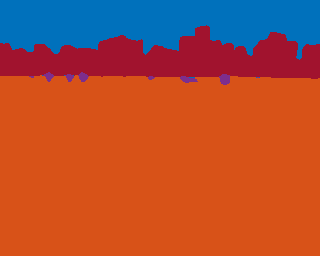

There are living obstacles and obstacles in the image a1635457058_004521_1_2.png
The position of the file is 74
indices where collapsed_pr_mask1_sqz has 0 value =  (array([41, 77, 78, 79]), array([ 36, 240, 174, 231]))


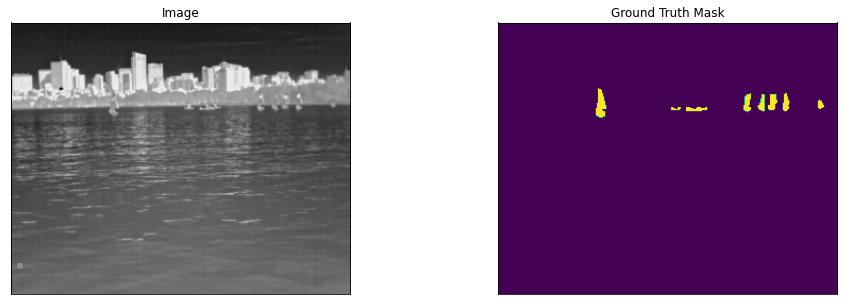

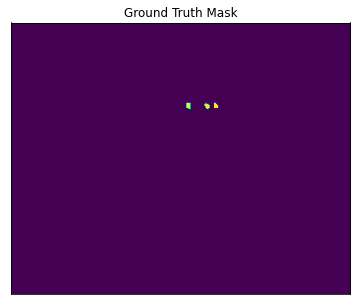

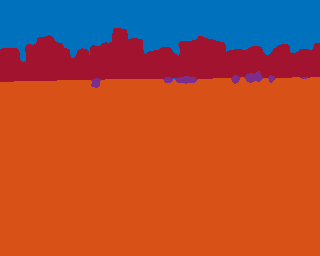

There are living obstacles and obstacles in the image a1571167625_633429_1_2.png
The position of the file is 75
indices where collapsed_pr_mask1_sqz has 0 value =  (array([78, 78, 79]), array([237, 241,  77]))


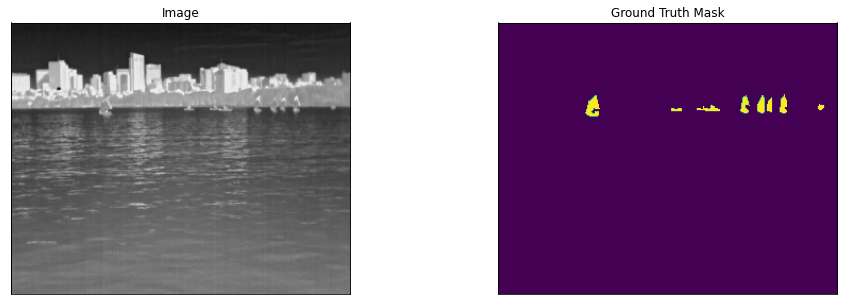

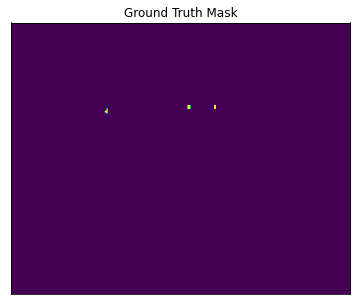

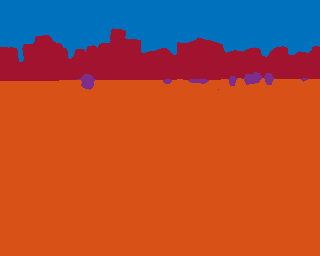

There are living obstacles and obstacles in the image a1635450088_023355_1_2.png
The position of the file is 76
indices where collapsed_pr_mask1_sqz has 0 value =  (array([68, 68, 71, 72, 72, 74, 74, 74]), array([ 56,  57,  45,   0,  75, 102, 112, 120]))


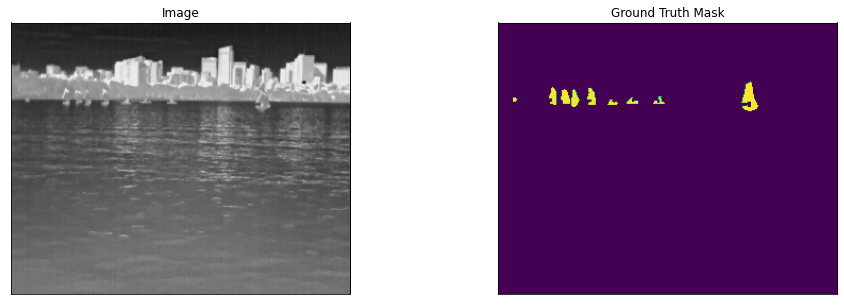

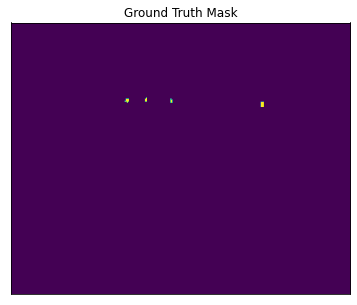

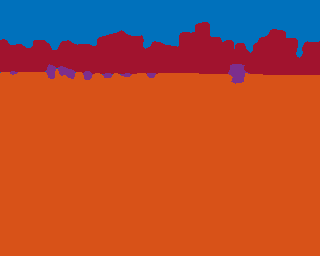

There are living obstacles and obstacles in the image a1571167631_166758_1_2.png
The position of the file is 77
indices where collapsed_pr_mask1_sqz has 0 value =  (array([76, 77, 78, 78, 78]), array([ 45, 100, 100, 144, 231]))


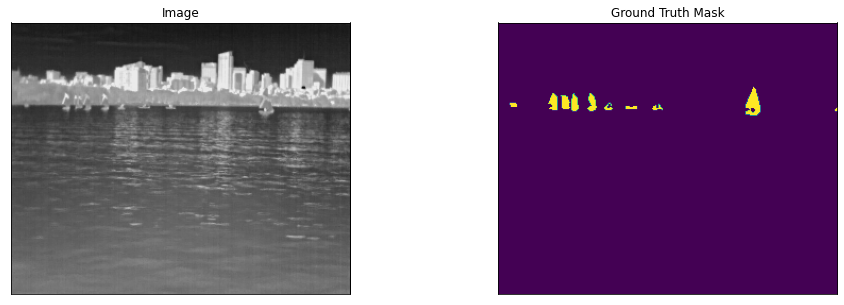

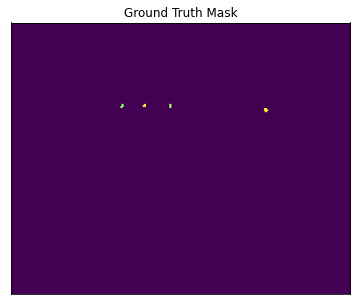

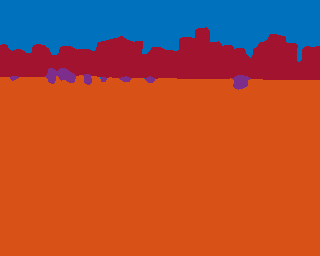

There are living obstacles and obstacles in the image a1576082284_027031_1_2.png
The position of the file is 78
indices where collapsed_pr_mask1_sqz has 0 value =  (array([74, 79, 79, 80, 80]), array([263, 302, 310, 187, 212]))


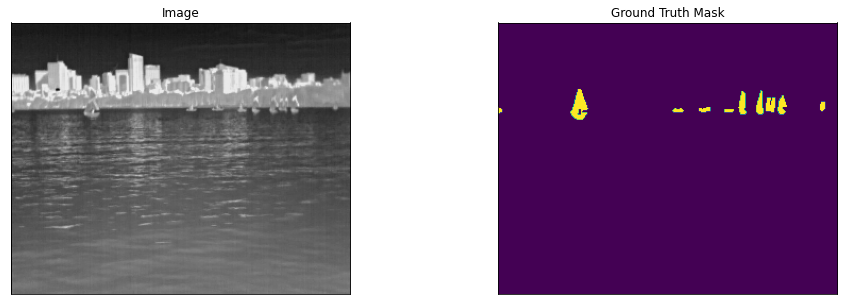

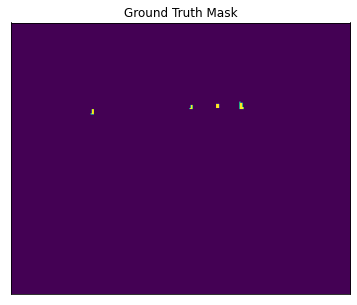

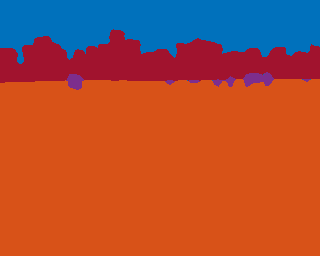

There are living obstacles and obstacles in the image a1572379693_647317_1_2.png
The position of the file is 79
indices where collapsed_pr_mask1_sqz has 0 value =  (array([76, 76, 76, 77, 77, 78, 81]), array([ 46,  91,  92,   8, 107, 143, 318]))


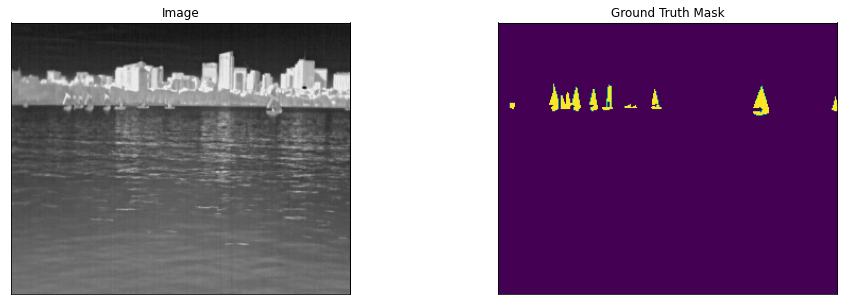

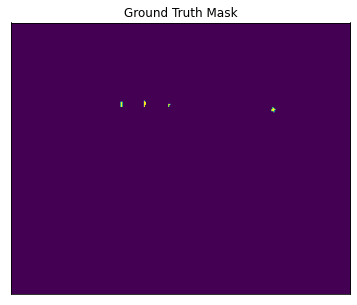

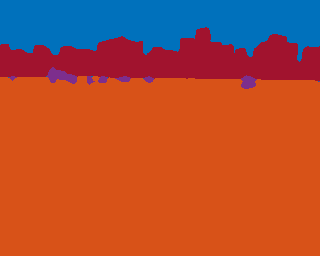

There are living obstacles and obstacles in the image a1635457844_013978_1_2.png
The position of the file is 80
indices where collapsed_pr_mask1_sqz has 0 value =  (array([80, 80, 81, 81]), array([227, 273,  80, 222]))


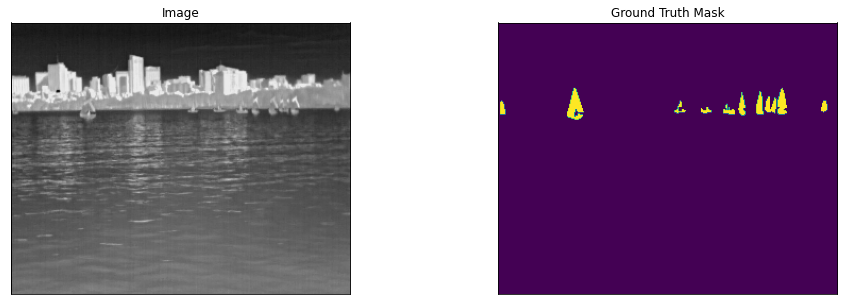

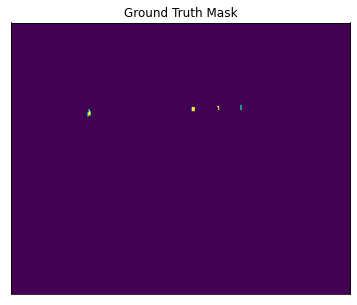

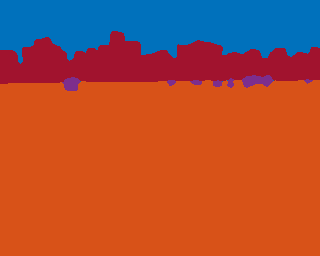

There are living obstacles and obstacles in the image a1572897145_103083_1_2.png
The position of the file is 81
indices where collapsed_pr_mask1_sqz has 0 value =  (array([77]), array([95]))


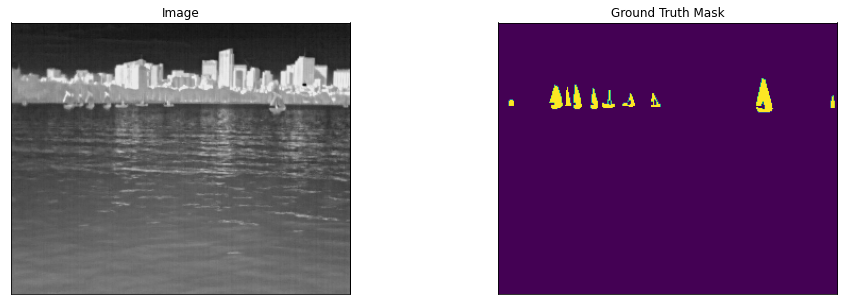

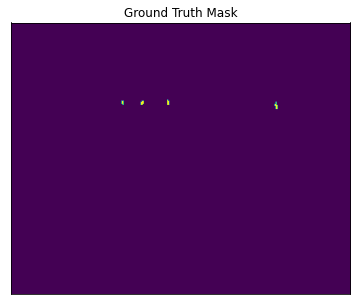

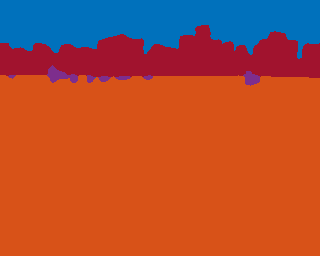

In [ ]:
# THIS COMBINES ALL CLASSES IN 1. FOR CHECKING EACH IMAGE SEPARATELY, CHANGE VALUE OF N. 
#FOR CHECKING ALL IMAGES TOGETHER, YOU WILL HAVE TO REMOVE N. AND USE I EVERYWHERE
#CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
import numpy as np 
import PIL
from PIL import Image


DEVICE = 'cuda'
rawimagefilenamelist = sorted(os.listdir(x_test_dir))
for i in range(50,100):
    #the below line will visualize for any random sample. we need specific. so i have removed it. keep changing value of n. 
    # i think value of i should loop thru no of classes.but we cna check it later
    #n = np.random.choice(len(test_dataset))
    #print("the iteration that is running is", i)
    image_name = rawimagefilenamelist[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
        
    #image_vis = test_dataset_vis[10][0].astype('uint8')
    #image, gt_mask = test_dataset[10]
    
    #print('gt mask before squeeze', np.unique(gt_mask))
    # only throw images if the ground truth has both obstacle and living obstacle 
    if (np.unique(gt_mask[3]).any() == 1) and (np.unique(gt_mask[4]).any() == 1):

    # only throw images if the ground truth has  obstacle but no living obstacle 
    #if (np.unique(gt_mask[3]).any() == 1) and (np.unique(gt_mask[4]).all() == 0) - checking if atleast an ob can be found:  
    #if (np.unique(gt_mask[3]).any() == 1) and (np.unique(gt_mask[4]).all() == 0) - checking if atleast an ob can be found:  
    #if (np.unique(gt_mask[6]).any() == 1 -- no self in test dataset ):  
       print("There are living obstacles and obstacles in the image",os.listdir(x_test_dir)[i])
       print("The position of the file is", i)
       gt_mask = gt_mask.squeeze()
       image_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
       #x_tensor = torch.from_numpy(image).unsqueeze(0)
       pr_mask = best_model.predict(image_tensor)
       pr_mask1 = (pr_mask.squeeze().cpu().numpy().round())
       #print("type of pr_mask", type(pr_mask))
       #print("shape of pr_mask", pr_mask.shape)
       #print("type of pr_mask1", type(pr_mask1))
       #print("shape of pr_mask1", pr_mask1.shape)
    
       #print("unique values of pr mask", np.unique(pr_mask))
       #print("unique values of gt mask", np.unique(gt_mask))
       #print("unique values of pr mask", np.unique(pr_mask1))
       #print("unique values of pr mask1", np.unique(pr_mask1))

       #want to save the array as an image#
       pr_mask1_sqz = pr_mask1.squeeze()
       #print ("shape of pr_mask1_sqz after squeeze", pr_mask1_sqz.shape)
       #print ("type of pr_mask1_sqz after squeeze", type(pr_mask1_sqz))
       #print("pr_mask1_sqz", np.unique(pr_mask1_sqz[2, :, :]))
       collapsed_pr_mask1_sqz = 1 * pr_mask1_sqz[0, :, :] + 2 * pr_mask1_sqz[1, :, :] + 3 * pr_mask1_sqz[2, :, :] + 4 * pr_mask1_sqz[3, :, :] + 5 * pr_mask1_sqz[4, :, :] + 6 * pr_mask1_sqz[5, :, :] + 7 * pr_mask1_sqz[6, :, :]    
       #print ("pr_mask1_sqz[0, 80, :] = ", pr_mask1_sqz[0, 109, :])
       #print ("pr_mask1_sqz[1, 80, :] = ", pr_mask1_sqz[1, 109, :])
       #print ("pr_mask1_sqz[2, 80, :] = ", pr_mask1_sqz[2, 109, :])
       #print ("pr_mask1_sqz[3, 80, :] = ", pr_mask1_sqz[3, 109, :])
       #print ("pr_mask1_sqz[4, 80, :] = ", pr_mask1_sqz[4, 109, :])
       #print ("pr_mask1_sqz[5, 80, :] = ", pr_mask1_sqz[5, 109, :])
       #print ("pr_mask1_sqz[6, 80, :] = ", pr_mask1_sqz[6, 109, :])
       #print ("Shape of collapsed_pr_mask1_sqz = {0}".format(collapsed_pr_mask1_sqz.shape))
       #print ("collapsed_pr_mask1_sqz = {0}".format(collapsed_pr_mask1_sqz))
       #print ("collapsed_pr_mask1_sqz[118] = {0}".format(collapsed_pr_mask1_sqz[118, :]))
       #print ("Unique values in collapsed_pr_mask1_sqz = ", np.unique(collapsed_pr_mask1_sqz))
       # Account for labeling correction: In earlier step, pr_mask_sqz[0, :, :] has to be multiplied by 1 to retain on-pixels. So 
       # subsequent classes also get (class no. + 1) as multiplier. So now subtract 1 to get back original ids in predicted
       result = np.where(collapsed_pr_mask1_sqz==0)
       print("indices where collapsed_pr_mask1_sqz has 0 value = ", result)
       #print ("values in collapsed_pr_mask1_sqz = ", collapsed_pr_mask1_sqz[25, :])
       #print ("Unique values in collapsed_pr_mask1_sqz = ", np.unique(collapsed_pr_mask1_sqz))
       # mask image
       collapsed_pr_mask1_sqz = collapsed_pr_mask1_sqz - 1 # why is this needed? 
       #print ("Unique values in collapsed_pr_mask1_sqz after subtraction = ", np.unique(collapsed_pr_mask1_sqz))
       #since pspnet is giving some pixels value of 0, which means none of the slices are being inferred in that pixel. 
       #changing that to sky so that there is no -1 in the array for visualization
       collapsed_pr_mask1_sqz = np.where(collapsed_pr_mask1_sqz == -1, 0, collapsed_pr_mask1_sqz)
       #print ("Unique values in collapsed_pr_mask1_sqz after changing -1 to 0 = ", np.unique(collapsed_pr_mask1_sqz))
       img_collapse = Image.fromarray(collapsed_pr_mask1_sqz) 
       img_collapse = img_collapse.convert("L")

       #Saving the category ids in an image for programatic IoU check 
       img_collapse.save('/content/drive/MyDrive/IRDatasetFinal-Inferences/pspnet/program/' + str(i) + '--run2020-1--' + image_name)
       
       #CLASSES = ['sky', 'water', 'bridge', 'obstacle', 'living obstacle', 'background', 'self']
       #              0.      1.       2.        3             4                 5           6
       visualize(
           image=image_vis,
           ground_truth_mask=gt_mask[3], 
           #predicted_mask=collapsed_pr_mask1_sqz
               )
     
       visualize(
           #image=image_vis,
           ground_truth_mask=gt_mask[4], 
           #predicted_mask=collapsed_pr_mask1_sqz
               )
     
       visualize2(
           #image=image_vis, 
           #ground_truth_mask=gt_mask[3], 
           predicted_mask=collapsed_pr_mask1_sqz,
           sequence = i,
           imagename = image_name 
                )
       
       




In [ ]:
'''
# out of 490, there are 340 images where there are empty pixels. Below code is to check if there are any 0s.
import numpy as np 
import PIL
from PIL import Image
DEVICE = 'cuda'
count = 0
for i in range(0,490):
    image_name = os.listdir(x_test_dir)[i]
    image_vis = test_dataset_vis[i][0].astype('uint8')
    image, gt_mask = test_dataset[i]
    #print("The position of the file is", i)
    gt_mask = gt_mask.squeeze()
    image_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(image_tensor)
    pr_mask1 = (pr_mask.squeeze().cpu().numpy().round())
    pr_mask1_sqz = pr_mask1.squeeze()
    collapsed_pr_mask1_sqz = 1 * pr_mask1_sqz[0, :, :] + 2 * pr_mask1_sqz[1, :, :] + 3 * pr_mask1_sqz[2, :, :] + 4 * pr_mask1_sqz[3, :, :] + 5 * pr_mask1_sqz[4, :, :] + 6 * pr_mask1_sqz[5, :, :] + 7 * pr_mask1_sqz[6, :, :]    
    result = np.where(collapsed_pr_mask1_sqz==0)
    
    if (len(result[0]) > 0): 
        #print("indices where collapsed_pr_mask1_sqz has 0 value = ", result)
        count = count+1 
print("total count of images where there are 0s" , count)
'''


total count of images where there are 0s 346
